<a href="https://colab.research.google.com/github/vicben2/hgraph2graph/blob/main/Parta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/wengong-jin/hgraph2graph

Cloning into 'hgraph2graph'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 364 (delta 113), reused 92 (delta 92), pack-reused 212 (from 1)
Receiving objects: 100% (364/364), 153.12 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (218/218), done.
Updating files: 100% (89/89), done.


In [2]:
%cd hgraph2graph

/content/hgraph2graph


In [9]:
!pip install rdkit networkx tqdm
import torch
from torch.utils.data import DataLoader
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import DataStructs
import sys
import os
from hgraph import HierVAE, MolGraph, common_atom_vocab, Vocab, PairVocab
from hgraph import MoleculeDataset

In [4]:
class Args:
  def __init__(self):
    self.vocab = None
    self.atom_vocab = common_atom_vocab
    self.rnn_type = 'LSTM'
    self.hidden_size = 250
    self.embed_size = 250
    self.batch_size = 20
    self.latent_size = 32
    self.depthT = 15
    self.depthG = 15
    self.diterT = 1
    self.diterG = 3
    self.dropout = 0.0

args = Args()

seed = 7

torch.manual_seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#vocab
vocab_path = 'data/chembl/vocab.txt'
vocab = [x.strip("\r\n ").split() for x in open(vocab_path)]
args.vocab = PairVocab(vocab, cuda=(device.type == 'cuda')) # FIX: Explicitly pass cuda argument

model_path = 'ckpt/chembl-pretrained/model.ckpt'
model = HierVAE(args).to(device)

checkpoint = torch.load(model_path, map_location=device)
if isinstance(checkpoint, tuple):
    model.load_state_dict(checkpoint[0])
else:
    model.load_state_dict(checkpoint)

model.eval()

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


HierVAE(
  (encoder): HierMPNEncoder(
    (E_c): Sequential(
      (0): Embedding(1578, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (E_i): Sequential(
      (0): Embedding(5623, 250)
      (1): Dropout(p=0.0, inplace=False)
    )
    (W_c): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_i): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (W_root): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): Tanh()
    )
    (tree_encoder): MPNEncoder(
      (W_o): Sequential(
        (0): Linear(in_features=500, out_features=250, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
      (rnn): LSTM(
        (W_i): Sequential(
          (0): Linear(in_features=520, out_features=250, bias=True)
          (1): Sigmoid()
       

In [15]:
input_smiles = [
    #aspirin, caffeine, paracetamol, ethanol, ibuprofen,
    #cholesterol, serotonin, morphine, glucose, nicotine
    "CC(=O)Oc1ccccc1C(=O)O",
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "CC(=O)Nc1ccc(O)cc1",
    "CCO",
    "CC(C)Cc1ccc(C(C)C(=O)O)cc1",
    "C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C",
    "C1=CC2=C(C=C1O)C(=CN2)CCN",
    "CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O",
    "C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O",
    "CN1CCC[C@H]1C2=CN=CC=C2"
]

valid_smiles = []
for s in input_smiles:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        can_smi = Chem.MolToSmiles(mol)
        valid_smiles.append(can_smi)
    else:
        print(f"Invalid: {s}")

In [16]:
def reconstruct_molecules(model, smiles_list, vocab, atom_vocab, batch_size=20):
    results = []

    compatible_smiles = []
    for smi in smiles_list:
        try:
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
            if ok:
                compatible_smiles.append(smi)
            else:
                results.append((smi, None, "Not in vocabulary"))
        except Exception as e:
            results.append((smi, None, f"Error:  {str(e)}"))

    if len(compatible_smiles) == 0:
        print("No compatible molecules found!")
        return results

    dataset = MoleculeDataset(compatible_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: x[0])

    #reconstruct
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Reconstructing"):
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(compatible_smiles))
            orig_smiles_batch = compatible_smiles[start_idx: end_idx]

            try:
                dec_smiles = model.reconstruct(batch)
                for orig, dec in zip(orig_smiles_batch, dec_smiles):
                    results.append((orig, dec, "Success"))
            except Exception as e:
                for orig in orig_smiles_batch:
                    results.append((orig, None, f"Decode error: {str(e)}"))

            batch_idx += 1

    return results

In [17]:
def calculate_tanimoto(smiles1, smiles2, radius=2, nBits=2048):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits=nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits=nBits)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

def get_mol_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        'num_atoms': mol. GetNumAtoms(),
        'num_bonds': mol.GetNumBonds(),
        'num_rings':  Chem.GetSSSR(mol).__len__(),
    }

def calculate_error_diagnostics(smiles_in, smiles_out):
    mol_in = Chem.MolFromSmiles(smiles_in)
    mol_out = Chem.MolFromSmiles(smiles_out)

    if mol_in is None or mol_out is None:
        return None

    props_in = get_mol_properties(smiles_in)
    props_out = get_mol_properties(smiles_out)

    return {
        'delta_atoms': props_out['num_atoms'] - props_in['num_atoms'],
        'delta_bonds': props_out['num_bonds'] - props_in['num_bonds'],
        'delta_rings': props_out['num_rings'] - props_in['num_rings'],
    }

def is_exact_match(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return False

    can1 = Chem.MolToSmiles(mol1)
    can2 = Chem. MolToSmiles(mol2)

    return can1 == can2

def is_valid_molecule(smiles):
    if smiles is None or smiles == "":
        return False
    mol = Chem. MolFromSmiles(smiles)
    return mol is not None

In [18]:
#results init
reconstruction_results = reconstruct_molecules(
    model,
    valid_smiles,
    args.vocab,
    args.atom_vocab,
    batch_size=args.batch_size
)

#experiment
results_data = []

for idx, (smiles_in, smiles_out, status) in enumerate(reconstruction_results):
    row = {
        'id': idx,
        'smiles_in': smiles_in,
        'smiles_out': smiles_out if smiles_out else "",
        'valid_out': 1 if is_valid_molecule(smiles_out) else 0,
        'exact_match': 1 if (smiles_out and is_exact_match(smiles_in, smiles_out)) else 0,
        'tanimoto':  None,
        'delta_atoms': None,
        'delta_bonds': None,
        'delta_rings': None,
        'status': status
    }

    if is_valid_molecule(smiles_out):
        row['tanimoto'] = calculate_tanimoto(smiles_in, smiles_out)

        diagnostics = calculate_error_diagnostics(smiles_in, smiles_out)
        if diagnostics:
            row['delta_atoms'] = diagnostics['delta_atoms']
            row['delta_bonds'] = diagnostics['delta_bonds']
            row['delta_rings'] = diagnostics['delta_rings']

    results_data.append(row)

df = pd. DataFrame(results_data)

#csv
df_csv = df[['id', 'smiles_in', 'smiles_out', 'valid_out', 'exact_match', 'tanimoto', 'delta_atoms', 'delta_bonds', 'delta_rings']].copy()
df_csv. to_csv('results.csv', index=False)

After pruning 8 -> 8


Reconstructing: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Summary:
                     Metric  Value
     Total Molecules Tested      5
      Valid Reconstructions      4
          Validity Rate (%)  80.00
              Exact Matches      3
   Exact Match Accuracy (%)  60.00
    Avg Tanimoto Similarity 0.7917
 Lowest Tanimoto Similarity 0.1667
Highest Tanimoto Similarity 1.0000

Error diagnostics:
 Diagnostic  Avg  Lowest  Highest
Delta Atoms 2.00     0.0      8.0
Delta Bonds 2.25     0.0      9.0
Delta Rings 0.25     0.0      1.0


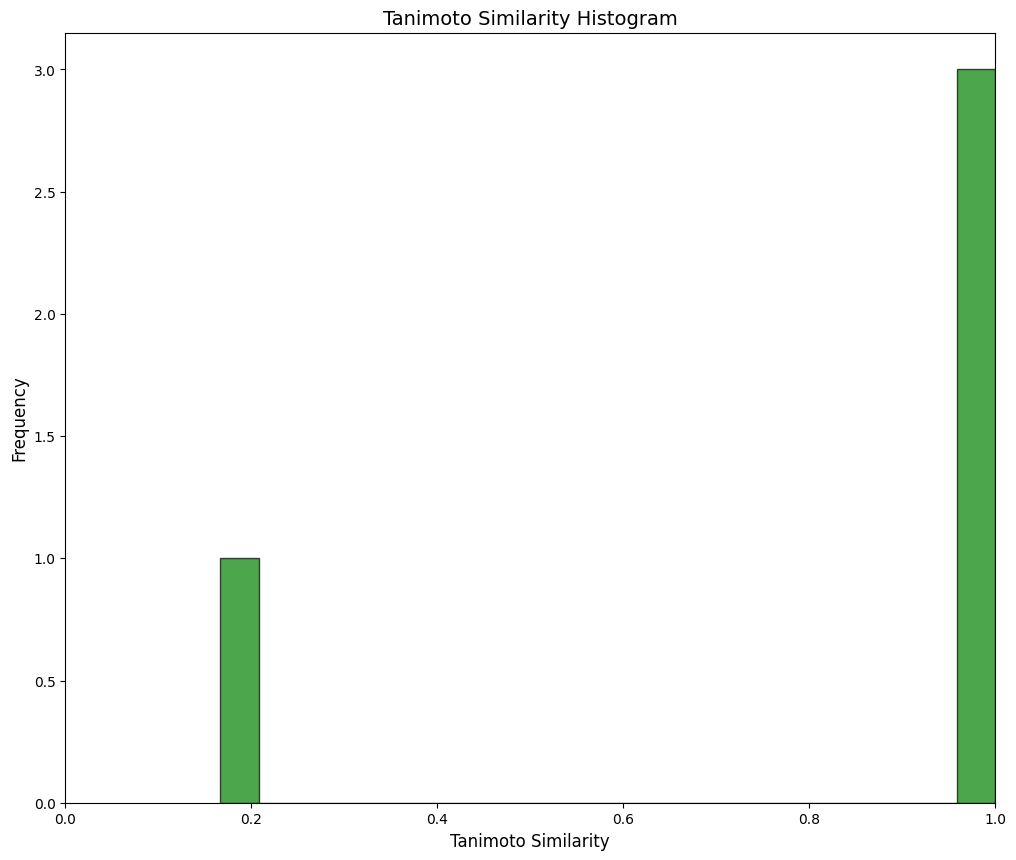

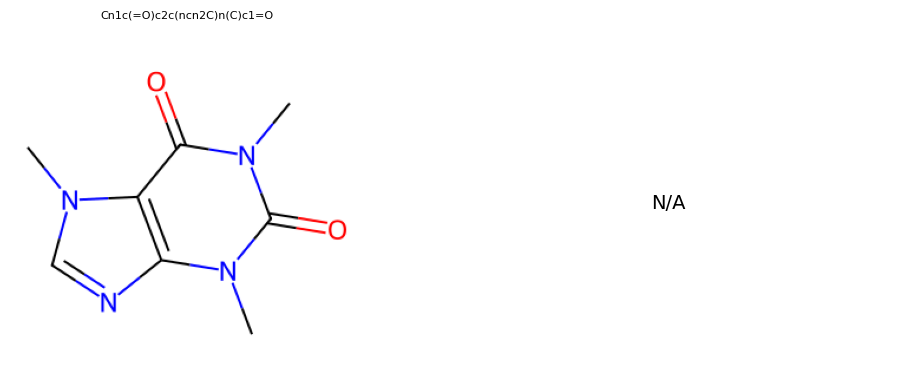

The model did not reconstruct Cn1c(=O)c2c(ncn2C)n(C)c1=O correctly.


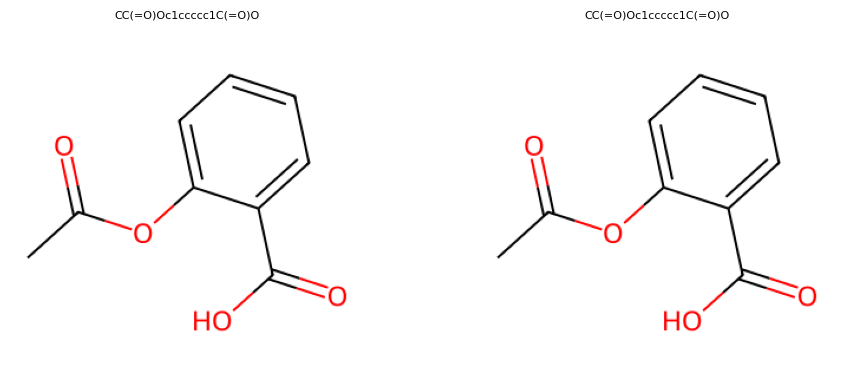

The model reconstructed CC(=O)Oc1ccccc1C(=O)O exactly.


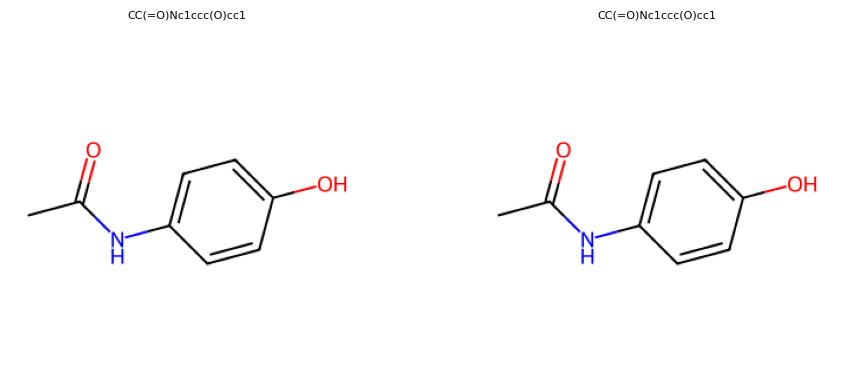

The model reconstructed CC(=O)Nc1ccc(O)cc1 exactly.


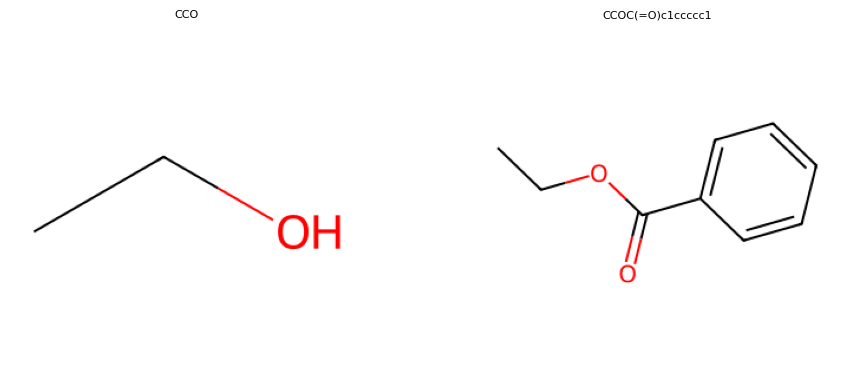

Significant reconstruction differences.


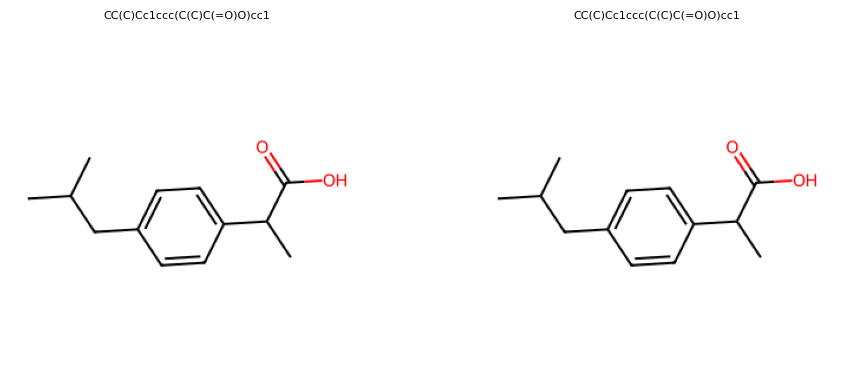

The model reconstructed CC(C)Cc1ccc(C(C)C(=O)O)cc1 exactly.


In [13]:
#summary
total_molecules = len(df)
valid_outputs = df['valid_out']. sum()
exact_matches = df['exact_match'].sum()
valid_df = df[df['valid_out'] == 1]

print("Summary:")

summary_table = pd.DataFrame({
    'Metric': [
        'Total Molecules Tested',
        'Valid Reconstructions',
        'Validity Rate (%)',
        'Exact Matches',
        'Exact Match Accuracy (%)',
        'Avg Tanimoto Similarity',
        'Lowest Tanimoto Similarity',
        'Highest Tanimoto Similarity',
    ],
    'Value': [
        total_molecules,
        valid_outputs,
        f"{100 * valid_outputs / total_molecules:.2f}" if total_molecules > 0 else "N/A",
        exact_matches,
        f"{100 * exact_matches / total_molecules:.2f}" if total_molecules > 0 else "N/A",
        f"{valid_df['tanimoto'].mean():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].min():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].max():.4f}" if len(valid_df) > 0 else "N/A",
    ]
})

print(summary_table.to_string(index=False))
print()

if len(valid_df) > 0:
    print("Error diagnostics:")

    error_summary = pd.DataFrame({
        'Diagnostic': ['Delta Atoms', 'Delta Bonds', 'Delta Rings'],
        'Avg': [
            f"{valid_df['delta_atoms'].mean():.2f}",
            f"{valid_df['delta_bonds'].mean():.2f}",
            f"{valid_df['delta_rings'].mean():.2f}"
        ],
        'Lowest': [
            valid_df['delta_atoms'].min(),
            valid_df['delta_bonds'].min(),
            valid_df['delta_rings'].min()
        ],
        'Highest': [
            valid_df['delta_atoms'].max(),
            valid_df['delta_bonds'].max(),
            valid_df['delta_rings'].max()
        ]
    })

    print(error_summary.to_string(index=False))

fig, ax1 = plt.subplots(figsize=(12, 10))

if len(valid_df) > 0:
    ax1.hist(valid_df['tanimoto'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='green')

ax1.set_xlabel('Tanimoto Similarity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Tanimoto Similarity Histogram', fontsize=14)
ax1.set_xlim(0, 1)

plt.show()
print()

def draw_molecules(smiles_in, smiles_out, idx, tanimoto, exact_match):
    mol_in = Chem.MolFromSmiles(smiles_in)
    mol_out = Chem.MolFromSmiles(smiles_out) if smiles_out else None

    fig, axes = plt. subplots(1, 2, figsize=(10, 4))

    # Input molecule
    if mol_in:
        img_in = Draw.MolToImage(mol_in, size=(300, 300))
        axes[0]. imshow(img_in)
        axes[0].set_title(f'{smiles_in}', fontsize=8)
    axes[0].axis('off')

    # Output molecule
    if mol_out:
        img_out = Draw.MolToImage(mol_out, size=(300, 300))
        axes[1].imshow(img_out)
        axes[1].set_title(f'{smiles_out}', fontsize=8)
    else:
        axes[1].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

    plt. tight_layout()
    return fig

examples = []
count = 10
for _, row in df.head(count).iterrows():
    if row['id'] not in [e['id'] for e in examples]:
        examples.append(row)
examples = examples[:10]

interpretations = []
for i, row in enumerate(examples):
    smiles_in = row['smiles_in']
    smiles_out = row['smiles_out']
    exact = row['exact_match']
    tanimoto = row['tanimoto']

    fig = draw_molecules(smiles_in, smiles_out, i, tanimoto, exact)
    plt.show()

    if exact:
        interp = f"The model reconstructed {smiles_in} exactly."
    elif row['valid_out'] == 0:
        interp = f"The model did not reconstruct {smiles_in} correctly."
    else:
        delta_atoms = row. get('delta_atoms', 0)
        delta_bonds = row.get('delta_bonds', 0)
        if tanimoto and tanimoto > 0.9:
            interp = f"Almost similar with minor differences."
        elif tanimoto and tanimoto > 0.7:
            interp = f"Good reconstruction noticeable differences."
        else:
            interp = f"Significant reconstruction differences."

    print(interp)